<a href="https://colab.research.google.com/github/briannalizbinoy/My-Projects/blob/main/2_2_Astrometry_Centroiding_Stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install astropy
!pip install photutils
!pip install matplotlib astropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from pathlib import Path
from astropy.io import fits
from astropy.stats import sigma_clip
import astropy.units as u
from astropy.coordinates import SkyCoord
from photutils.detection import DAOStarFinder
import zipfile
import os
from glob import glob
from scipy.optimize import curve_fit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


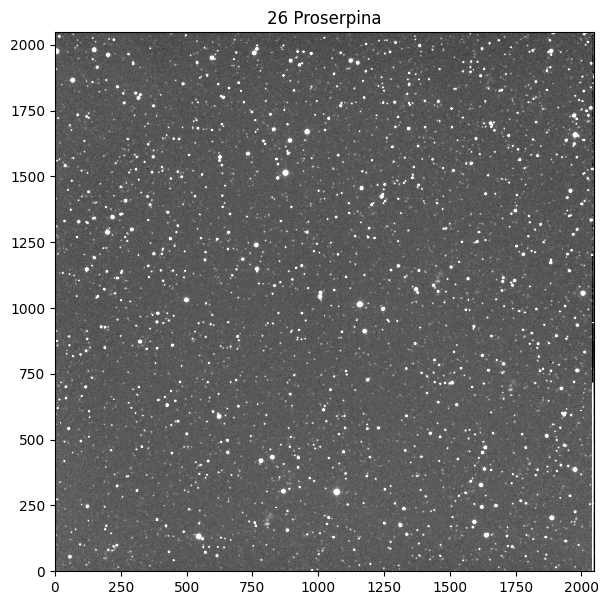

In [ ]:
from astropy.io import fits
data = fits.open('/content/drive/MyDrive/26Proserpina/Cleaned/cleaned_20120119_0.fits')[0].data

# Take a look at your image
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

plt.figure(figsize=(7,7))
vmin,vmax = ZScaleInterval().get_limits(data)
plt.imshow(data, vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
plt.title('26 Proserpina');

In [ ]:
data.shape

(2048, 2048)

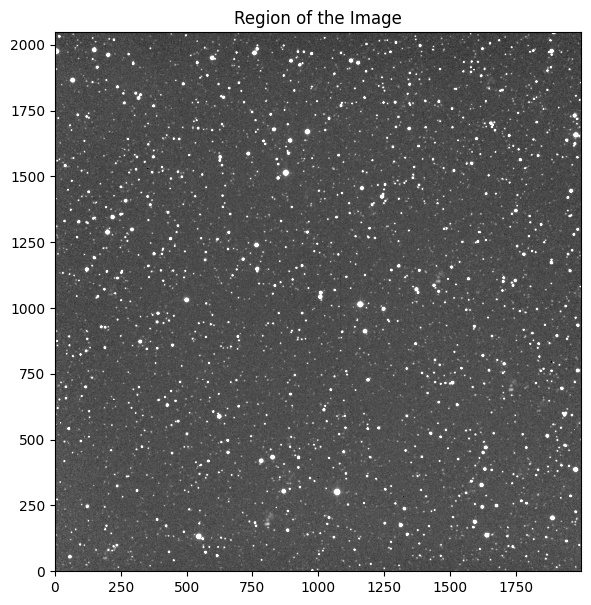

In [ ]:
region = data[0:2048,0:2000]
vmin,vmax = ZScaleInterval().get_limits(region)
plt.figure(figsize=(7,7))
plt.imshow(region, vmin=vmin, vmax=vmax, cmap='gray', origin = 'lower')
plt.title('Region of the Image');

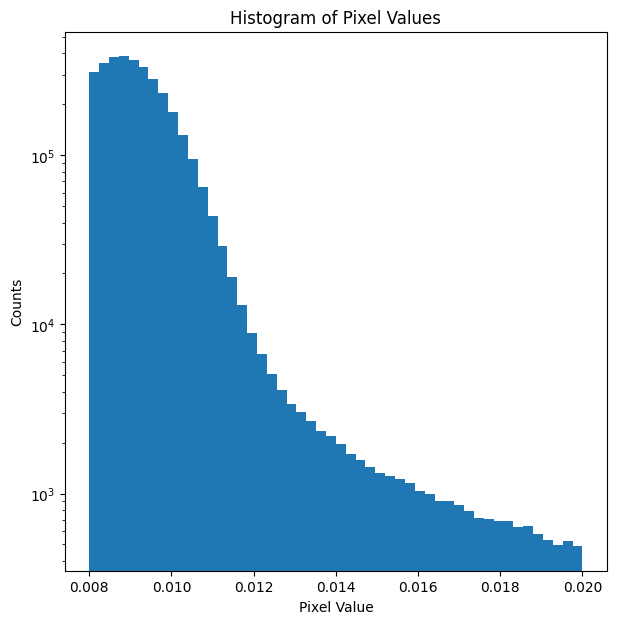

In [ ]:
# What threshold should we use to determine what is a bright point?
# Lets take a look at the histogram of the image
plt.figure(figsize=(7,7))
# Play around with the range to get a sense of what pixel values are most common or rare
plt.hist(data.flatten(),bins=50,range=(0.008,0.02))
plt.yscale('log')
plt.xlabel('Pixel Value')
plt.ylabel('Counts')
plt.title('Histogram of Pixel Values');

In [ ]:
saturated_threshhold = np.percentile(region, 99.9)
saturated_positions = np.array(np.where(region > saturated_threshhold))
print(f"{len(saturated_positions[0])} pixels seem to be saturated")

# Create a mask
mask = np.ones_like(region)
# Decide how big of an aperture you want to use to mask out the saturated stars
width = 10

for pix in saturated_positions.T:
    # Create a circle around that pixel
    yy, xx = np.mgrid[:region.shape[0], :region.shape[1]]
    circle = (xx - pix[1])**2 + (yy - pix[0])**2
    circle = circle < width**2
    # Set the pixels inside the circle to 0
    mask[circle] = 0

# Multiply the mask by your data
masked_region = region * mask

# Take a look
plt.figure(figsize=(7,7))
plt.imshow(masked_region, vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
plt.title('Region of the Image');

4096 pixels seem to be saturated


KeyboardInterrupt: 

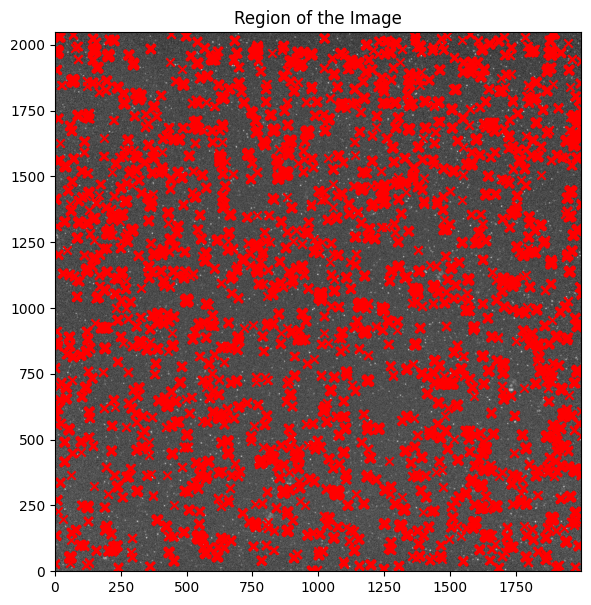

In [ ]:
# Now we want to find the brightest points in the image for the normal stars so we can center them and find their centroids
# Pick a value from the histogram we just plotted that you think may exclude the background but include the stars
threshhold = 0.017
mask = np.ones_like(region)
masked_region = region * mask
# Find pixel positions where the intensity of the pixel is greater than the threshhold
bright_points = np.array(np.where(masked_region > threshhold))

# Remember to be careful of how indexing works in python
# The first index is the y position, the second index is the x position
xs = bright_points[1]
ys = bright_points[0]

plt.figure(figsize=(7,7))
plt.imshow(region, vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
plt.title('Region of the Image');
plt.scatter(xs,ys,marker='x',color='red',label='Bright Points')

In [ ]:
from scipy.spatial.distance import cdist

def fuse_close_points(points, distance_threshold):
    points = np.array(points)
    pairwise_distances = cdist(points, points)

    merged_points = []
    merged_indices = set()

    for i in range(len(points)):
        if i not in merged_indices:
            close_points_indices = np.where(pairwise_distances[i] < distance_threshold)[0]

            # Merge close points
            merged_point = np.median(points[close_points_indices], axis=0)
            # merged_point = points[close_points_indices][0]
            merged_points.append(merged_point)

            # Mark merged indices
            merged_indices.update(close_points_indices)

    return np.array(merged_points)

In [ ]:
print(stars.shape)
print(bright_points.shape)
print(bright_points.T.shape)

NameError: name 'stars' is not defined

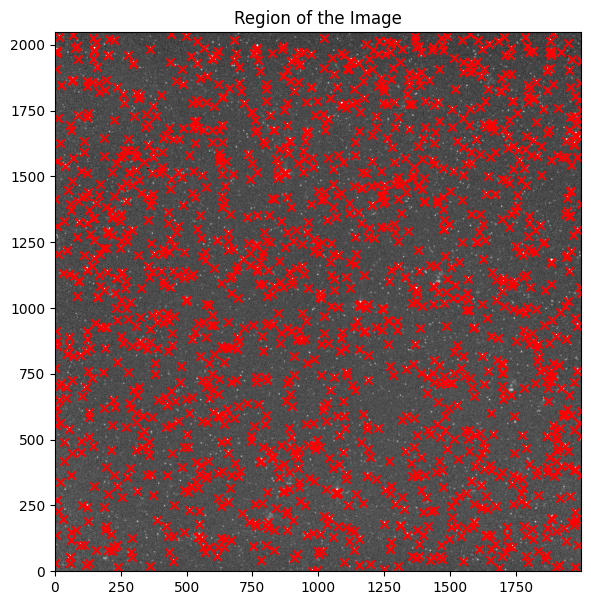

In [ ]:
stars = np.array(fuse_close_points(np.array([xs, ys]).T, 10).T)

plt.figure(figsize=(7,7))
plt.imshow(region, vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
plt.title('Region of the Image');
plt.scatter(*stars, marker='x',color='red',label='Bright Points')
# plt.scatter(stars[0],stars[1])

In [ ]:
stars[0]


array([117.5,   1. ,  57. , 128. , 155. , 111. ,  95. ,  59. ,   2.5,
        62. ,  78. , 190. , 127. ,  29. ])

In [ ]:
import numpy as np

def centroid(image):
    """
    Calculate the centroid of an image.

    Parameters:
    - image: 2D numpy array representing the image.

    Returns:
    - x_center, y_center: Coordinates of the centroid.
    """
    # Generate coordinate grids
    y, x = np.indices(image.shape)

    # Calculate the total intensity
    total_intensity = np.sum(image)

    # Calculate the x and y centroid coordinates
    x_center = np.sum(x * image) / total_intensity
    y_center = np.sum(y * image) / total_intensity

    return x_center, y_center


In [ ]:
stars[1][12]

190.0

(964.0, 988.0)

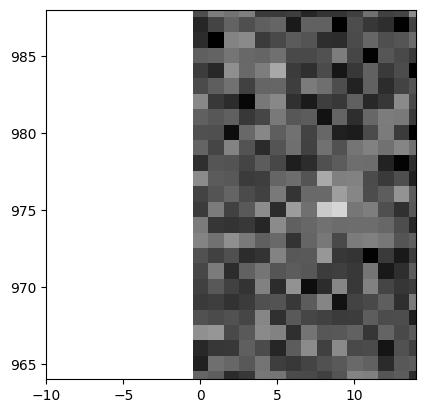

In [ ]:
pos = data
plt.imshow(pos, vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
plt.xlim([stars[1][0]-12, stars[1][0]+12])
plt.ylim([(stars[0][0])-12, (stars[0][0])+12])

<ipython-input-10-0312d2cc19c3>:20: RuntimeWarning: invalid value encountered in double_scalars
  x_center = np.sum(x * image) / total_intensity
<ipython-input-10-0312d2cc19c3>:21: RuntimeWarning: invalid value encountered in double_scalars
  y_center = np.sum(y * image) / total_intensity


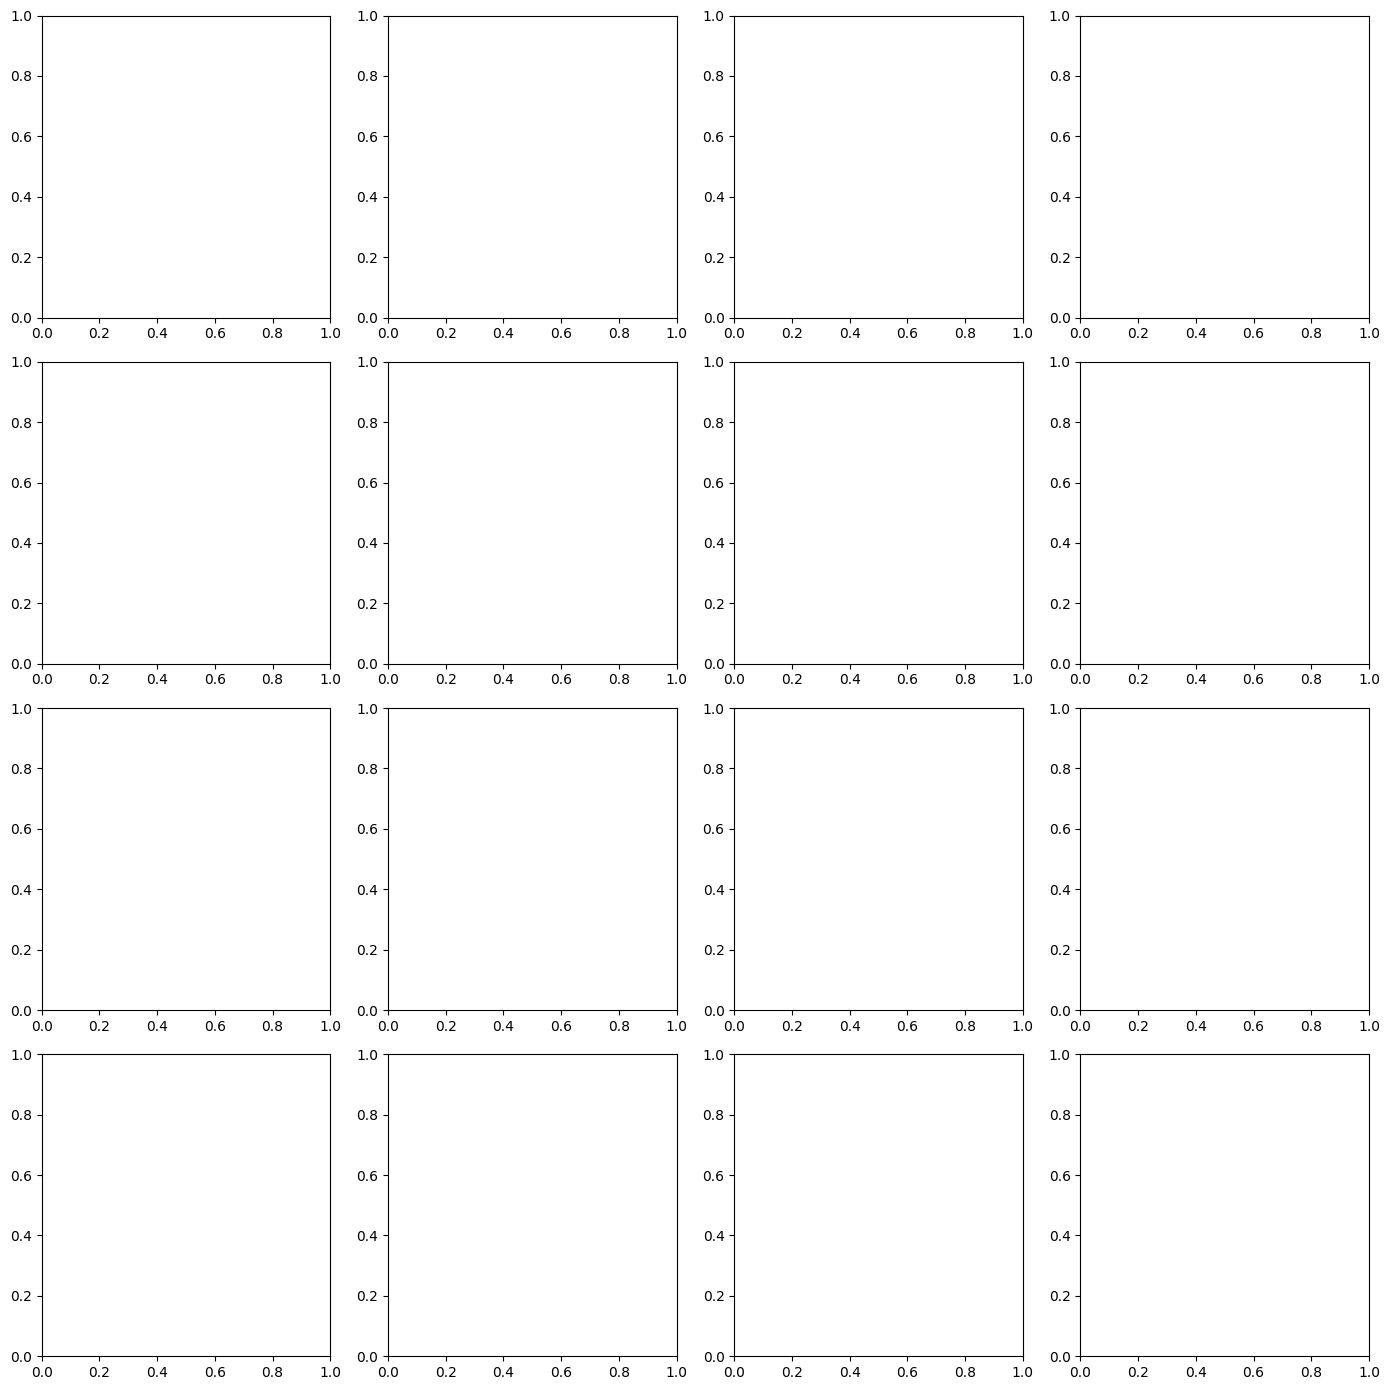

In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

fig, ax = plt.subplots(4, 4, figsize=(14, 14))  # Adjust the figure size if needed
cent_xs = []
cent_ys = []
for i in range(len(stars[0])):
    x, y = stars[:,i]
    if x < 13 or x > data.shape[1] - 13 or x < 13 or x > data.shape[0] - 13:
      continue;
    pos = data[int(stars[1][i])-12:int(stars[1][i])+12, int(stars[0][i])-12:int(stars[0][i])+12]
    x_centroid, y_centroid = centroid(pos)
    cent_xs.append(x_centroid)
    cent_ys.append(y_centroid)
    # row, col = divmod(i, 4)  # Calculate the row and column indices for subplot
    # ax[row, col].scatter(x_centroid, y_centroid, marker='x',color='red',label='Bright Points')
    # # vmin, vmax = ZScaleInterval().get_limits(pos)
    # ax[row, col].imshow(pos, cmap='gray', origin='lower')
    # ax[row, col].set_title('Region of the Image')
    # plt.xlim([stars[1][i]-12, stars[1][i]+12])
    # plt.ylim([(stars[0][i])-12, (stars[0][i])+12])

plt.tight_layout()  # Add this line for better layout
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# fig, ax = plt.subplots(4, 4, figsize=(14, 14))  # Adjust the figure size if needed
cent_xs = []
cent_ys = []
for i in range(len(stars[0])):
    pos = data[int(stars[1][i])-12:int(stars[1][i])+12, int(stars[0][i])-12:int(stars[0][i])+12]
    x_centroid, y_centroid = centroid(pos)
    cent_xs.append(x_centroid)
    cent_ys.append(y_centroid)
    # row, col = divmod(i, 4)  # Calculate the row and column indices for subplot
    # ax[row, col].scatter(x_centroid, y_centroid, marker='x',color='red',label='Bright Points')
    # # vmin, vmax = ZScaleInterval().get_limits(pos)
    # ax[row, col].imshow(pos, cmap='gray', origin='lower')
    # ax[row, col].set_title('Region of the Image')

# plt.tight_layout()  # Add this line for better layout
# plt.show()


<ipython-input-10-0312d2cc19c3>:20: RuntimeWarning: invalid value encountered in double_scalars
  x_center = np.sum(x * image) / total_intensity
<ipython-input-10-0312d2cc19c3>:21: RuntimeWarning: invalid value encountered in double_scalars
  y_center = np.sum(y * image) / total_intensity


In [ ]:
stars.shape

(2, 1505)

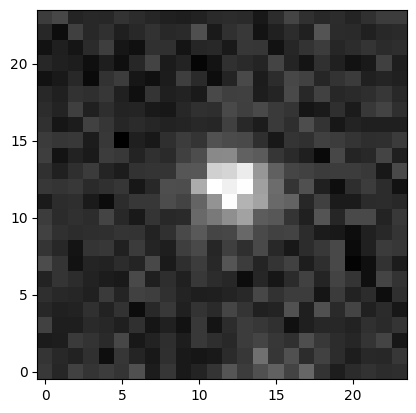

In [ ]:
pos = data[int(stars[1][8])-12:int(stars[1][8])+12, int(stars[0][8])-12:int(stars[0][8])+12]
plt.imshow(pos, cmap='gray', origin='lower')


In [ ]:
cent_xs_new = []
cent_ys_new = []
for i in range(len(cent_xs)):
  cent_xs_new.append(cent_xs[i]+stars[0][i]-12)
  cent_ys_new.append(cent_ys[i]+stars[1][i]-12)
print(cent_xs_new)
print(cent_ys_new)

import math

cent_xs_new_filtered = []
cent_ys_new_filtered = []

# Assuming cent_xs_new and cent_ys_new have been previously defined

for i in range(len(cent_xs_new)):
    if not math.isnan(cent_xs_new[i]) and not math.isnan(cent_ys_new[i]):
        # Add non-NaN values to the new lists
        cent_xs_new_filtered.append(cent_xs_new[i])
        cent_ys_new_filtered.append(cent_ys_new[i])

print(cent_xs_new_filtered)
print(cent_ys_new_filtered)

cent_xs = cent_xs_new_filtered
cent_ys = cent_ys_new_filtered


[nan, nan, nan, 1903.227021063399, 239.44227074522715, 1685.0666479445115, 1975.4777902559379, 360.0218851260659, 1304.6169222553237, 1155.5584683944446, 1913.0292549563978, 117.27255143321119, 1197.5456850290805, nan, 1096.3805673666386, 56.55102768384957, 127.21673956286625, 1797.0437755472844, 449.5916709163964, 1549.6014933281426, 783.514548106961, 1651.5269839471423, 1423.6772435165853, 1862.5125548603498, 1471.0618578921649, 55.8913877977067, 1372.9560604726062, 906.5044160641309, 291.98835332041585, 1436.2888272321559, 614.6499129002559, 1787.5548989286367, 1463.6582432598505, 1697.544254233992, 1357.5197995479505, 1383.4396416095065, 56.319096522683694, 1866.026539289421, 1001.1182987819105, 918.5662484619222, 570.5983323926099, 431.6548032659686, 286.4158931817583, 1710.4358843769753, 1833.5143032439776, 1015.556520410614, 216.5426035371957, 201.613949856356, 997.6541966548871, 154.4897456203957, 1136.1523751576426, 829.9810724266486, 1611.5355071591196, 1273.2390921519013, 16

In [ ]:
import pandas as pd
# Make a dictionary of the positions of the centroids
centroids = {'x':cent_xs,'y':cent_ys}
# Save the dictionary to a file
my_catalog = pd.DataFrame(centroids)
my_catalog.to_csv('/content/drive/MyDrive/26Proserpina/Centroids/20120199_1.csv',index=False)
my_catalog


,x,y
0,1903.227021,13.614670
1,239.442271,13.542421
2,1685.066648,13.028145
3,1975.477790,14.947898
4,360.021885,19.550168
...,...,...
1588,1487.529509,2033.465047
1589,68.022324,2037.050866
1590,440.095118,2038.086284
1591,1576.530416,2038.070297


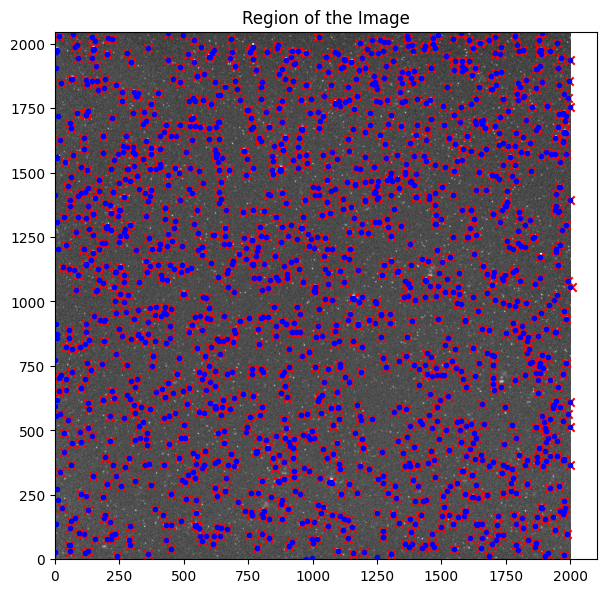

In [ ]:


plt.figure(figsize=(7,7))
plt.imshow(region, vmin=vmin, vmax=vmax, cmap='gray', origin='lower')
plt.title('Region of the Image');
plt.scatter(cent_xs, cent_ys, marker='x',color='red',label='Bright Points')
plt.scatter(*stars, marker='.',color='blue',label='Bright Points')
# plt.scatter(stars[0],stars[1])

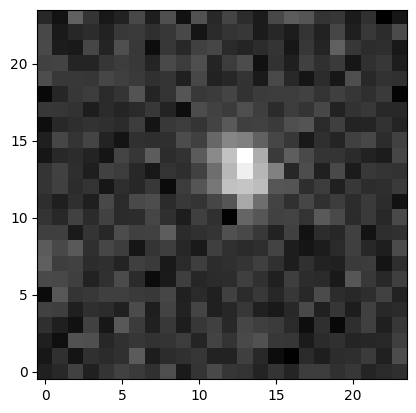

In [ ]:
pos = data[int(cent_ys[1])-12:int(cent_ys[1])+12, int(cent_xs[1])-12:int(cent_xs[1])+12]
plt.imshow(pos, cmap='gray', origin='lower')


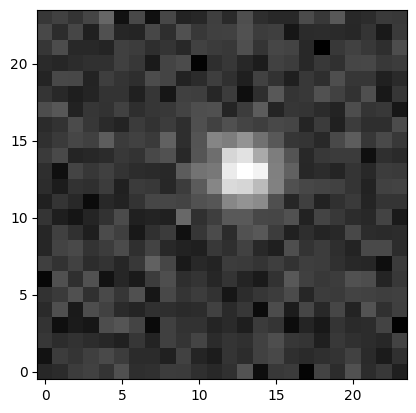

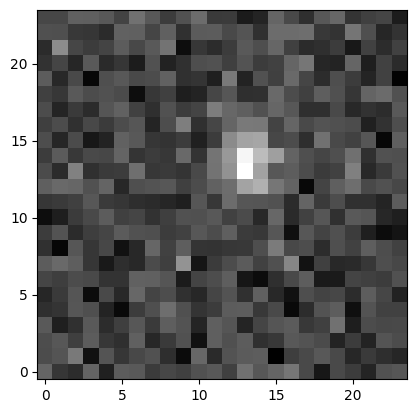

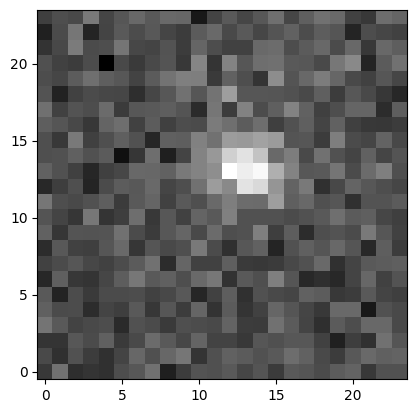

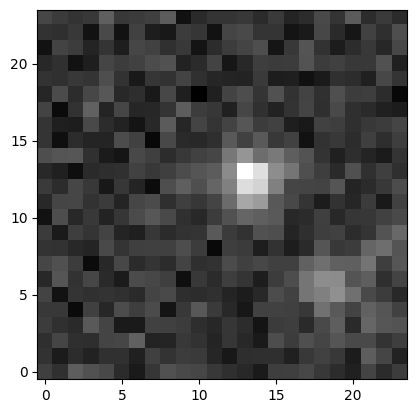

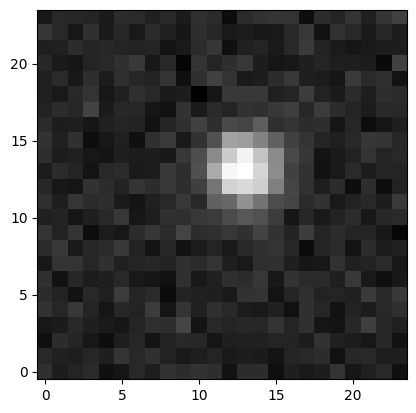

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming cent_xs and cent_ys have been previously defined

for _ in range(5):
    # Replace this line with your preferred method of getting integer values from 1 to 1500
    random_cent_index = np.random.randint(1, 1501)

    cent_x = int(cent_xs[random_cent_index]) - 12
    cent_y = int(cent_ys[random_cent_index]) - 12

    # Assuming data is a 2D array representing your image data
    pos = data[cent_y:cent_y + 24, cent_x:cent_x + 24]

    plt.imshow(pos, cmap='gray', origin='lower')
    # plt.scatter(cent_x, cent_y)
    plt.show()
